# Plot3D Python Tutorial
In this tutorial you will learn about the Plot3D NASA Standard and how to use NASA's Plot3D python library to read, write, find connectivity, split blocks, and find periodicity.

## About Plot3D
Plot3D is a standard for defining a simple structured grid. This standard was developed in the 1980's [User Manual](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiLm_2Q8JjzAhUCB50JHTfFCM4QFnoECAMQAQ&url=https%3A%2F%2Fwww.grc.nasa.gov%2Fwww%2Fwinddocs%2Ftowne%2Fplotc%2Fplotc_p3d.html&usg=AOvVaw0iKPGjnhjiQA9AFZcFhkEE) 

To understand the plot3D standard, we must first start with the definition of an array. The figure below shows a box with 6 faces and 8 verticies represented by black dots. Now if you were to discretize a geometry into many of these boxes all connected to each other. You would have many x,y,z points. To organize things we arrange all this points into an array of x's, y'z, z's and we label them as capital X, Y, Z. 

![Array](https://raw.githubusercontent.com/nasa/Plot3D_utilities/main/colab/images/array_definition.png)

So what does this mean? how is this helpful. It depends on how to arrange the array. If you have a single dimensional array of x like x<sub>1</sub>,x<sub>2</sub>,x<sub>3</sub>, ..., x<sub>n</sub>. This isn't particularly useful because it's hard to split it in to faces - just try it with the simple box above. So what we do instead is represent x as a 3-dimensional array instead of a single dimension. For example x[0,0,0] or x<sub>0,0,0</sub> = some value. 
The image below shows how we arrange the x values of each of the vertices. 


![Array](https://raw.githubusercontent.com/nasa/Plot3D_utilities/main/colab/images/array_definition2.png)

With this new arrangement of x into a 3-dimensional array, x[i,j,k]. We can easily extract a face. For example the front face is defined by x[0,0,0] x[1,0,0], x[0,1,0], x[1,1,0]. Do you notice anything interesting from this array? The third index "k" is 0. **To define a face you simply set either i, j, or k to be a constant value.** For outer faces you would use KMIN or KMAX. Depending on the programming language the indicies may start at 1 or 0. In python we start at 0 and end at n-1. [More info on Python Arrays](https://www.w3schools.com/python/python_arrays.asp)





# Environment Setup
This step is relatively short. Run the code below to install plot3d 

In [10]:
!pip install plot3d

ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint


# Reading and Writing a mesh file 
In simple words, a mesh is a collection of boxes arranged to form a shape. In this example we will explore reading a mesh in ASCII and saving it into a binary format. 




## Step 1: Load the functions from the library

In [11]:
from plot3d import read_plot3D, write_plot3D,Block
import pickle
import pprint

## Step 2: Download and read the mesh file
The code below reads the plot3D into a variable called blocks. "blocks" is a variable representing an array of plot3D blocks. You can think of a block as a 6 sided cube but inside the cube you have multiple smaller cubes. Cubes can be stretched and wrapped such that two ends are connected. This is called an o-mesh. We will plot this in a later step. 

In [2]:
!wget https://nasa-public-data.s3.amazonaws.com/plot3d_utilities/PahtCascade-ASCII.xyz

--2021-09-29 14:56:39--  https://nasa-public-data.s3.amazonaws.com/plot3d_utilities/PahtCascade-ASCII.xyz
Resolving nasa-public-data.s3.amazonaws.com (nasa-public-data.s3.amazonaws.com)... 52.217.76.220
Connecting to nasa-public-data.s3.amazonaws.com (nasa-public-data.s3.amazonaws.com)|52.217.76.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82072023 (78M) [application/x-www-form-urlencoded]
Saving to: ‘PahtCascade-ASCII.xyz’

PahtCascade-ASCII.x 100%[===================>]  78.27M  71.0MB/s    in 1.1s    

2021-09-29 14:56:41 (71.0 MB/s) - ‘PahtCascade-ASCII.xyz’ saved [82072023/82072023]



In [3]:
blocks = read_plot3D('PahtCascade-ASCII.xyz',binary=False)  # Reading plot3D
write_plot3D('PahtCascade-ASCII.xyz',blocks,binary=True)    # Writing plot3D to binary file

### Plotting the Mesh
The function below shows how we can plot an outline of the mesh 

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np 

def plot_block_outline(block:Block,ax:axes3d):
  IMAX,JMAX,KMAX = block.X.shape
  X = block.X 
  Y = block.Y
  Z = block.Z 

  for i in [0,IMAX-1]:    # Plots curves at constant I bounds 
    for j in [0,JMAX-1]:
      x = X[i,j,:]
      y = Y[i,j,:]
      z = Z[i,j,:]
      ax.plot3D(x,y,z)
  for j in [0,JMAX-1]:    # Plots curves at constant I bounds 
      for k in [0,KMAX-1]:
        x = X[:,j,k]
        y = Y[:,j,k]
        z = Z[:,j,k]
        ax.plot3D(x,y,z)
  for i in [0,JMAX-1]:    # Plots curves at constant I bounds 
      for k in [0,KMAX-1]:
        x = X[i,:,k]
        y = Y[i,:,k]
        z = Z[i,:,k]
        ax.plot3D(x,y,z)


Try playing with this code to see if you can plot one block at a time. Also try changing the rotation 

we have 2 blocks


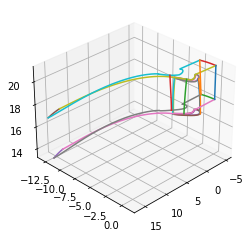

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_block_outline(blocks[0],ax)
plot_block_outline(blocks[1],ax)
ax.view_init(30,45)

print("we have " + str(len(blocks)) + " blocks")

# Finding Connectivity
Connectivity tells the solver how information should transfer between Faces. For example, lets look at the example above. We have 2 blocks `blocks[0]` and `blocks[1]` These are connected via the pressure side of the blade. One of the features of the plot3d library is the ability to find connected faces between blocks as well as all the connected points. 

## Finding Connected Faces

The function `connectivity` takes in a parameter for blocks. The output is a list of face matches between blocks along with the outer faces which are faces that do not have a connection to another block. 

In [12]:
from plot3d import connectivity
face_matches, outer_faces_formatted = connectivity(blocks)  # Running this code will take a while depending on how fast google colab is on a given day.
# Saving the results
with open('connectivity.pickle','wb') as f:
  pickle.dump({"face_matches":face_matches, "outer_faces":outer_faces_formatted},f)

Checking connections block 0 with 1: 100%|██████████| 1/1 [07:58<00:00, 478.99s/it]


`face_matches` contains matching face diagonals. The simpliest way to represent a face match is to use the following standard:

### Representing connected faces 
Block Index1 Face lower corner represented as [IMIN,JMIN,KMIN] Face Upper corner represented as [IMAX,JMAX,KMAX]. This matches Block Index2 Face lower corner represented as [IMIN,JMIN,KMIN] Face Upper corner represented as [IMAX,JMAX,KMAX]. 

`face_matches[0]['match']` is a dataframe of connected points. This is available to you in case you want to use it. 

You can see that below when we print out the dictionary 

In [28]:
with open('connectivity.pickle','rb') as f:
  data = pickle.load(f)
  face_matches = data['face_matches']
  outer_faces = data['outer_faces']

face_matches
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(face_matches[0])

{   'block1': {   'IMAX': 256,
                  'IMIN': 128,
                  'JMAX': 100,
                  'JMIN': 0,
                  'KMAX': 32,
                  'KMIN': 32,
                  'block_index': 0},
    'block2': {   'IMAX': 168,
                  'IMIN': 40,
                  'JMAX': 100,
                  'JMIN': 0,
                  'KMAX': 0,
                  'KMIN': 0,
                  'block_index': 1},
    'match':         i1   j1  k1   i2   j2 k2
101    128    0  32   40    0  0
102    128    1  32   40    1  0
103    128    2  32   40    2  0
104    128    3  32   40    3  0
105    128    4  32   40    4  0
...    ...  ...  ..  ...  ... ..
13125  256   96  32  168   96  0
13126  256   97  32  168   97  0
13127  256   98  32  168   98  0
13128  256   99  32  168   99  0
13129  256  100  32  168  100  0

[13029 rows x 6 columns]}


## Plotting Connected Faces

In [113]:
from matplotlib import cm
import numpy as np 

def select_multi_dimensional(T:np.ndarray,dim1:tuple,dim2:tuple, dim3:tuple):
    """Takes a block (T) and selects X,Y,Z from the block given a face's dimensions
        theres really no good way to do this in python 
    Args:
        T (np.ndarray): arbitrary array so say a full matrix containing X
        dim1 (tuple): 20,50 this selects X in the i direction from i=20 to 50
        dim2 (tuple): 40,60 this selects X in the j direction from j=40 to 60
        dim3 (tuple): 10,20 this selects X in the k direction from k=10 to 20

    Returns:
        np.ndarray: returns X or Y or Z given some range of I,J,K
    """
    if dim1[0] == dim1[1]:
        return T[ dim1[0], dim2[0]:dim2[1]+1, dim3[0]:dim3[1]+1 ]
    if dim2[0] == dim2[1]:
        return T[ dim1[0]:dim1[1]+1, dim2[0], dim3[0]:dim3[1]+1 ]
    if dim3[0] == dim3[1]:
        return T[ dim1[0]:dim1[1]+1, dim2[0]:dim2[1]+1, dim3[0] ]
    
    return T[dim1[0]:dim1[1], dim2[0]:dim2[1], dim3[0]:dim3[1]]

def plot_face(face_matches,blocks):
  for fm in face_matches:
    block_index1 = fm['block1']['block_index']
    I1 = [fm['block1']['IMIN'],fm['block1']['IMAX']] # [ IMIN IMAX ]
    J1 = [fm['block1']['JMIN'],fm['block1']['JMAX']] # [ JMIN JMAX ]
    K1 = [fm['block1']['KMIN'],fm['block1']['KMAX']] # [ KMIN KMAX ]

    block_index2 = fm['block2']['block_index']
    I2 = [fm['block2']['IMIN'],fm['block2']['IMAX']] # [ IMIN IMAX ]
    J2 = [fm['block2']['JMIN'],fm['block2']['JMAX']] # [ JMIN JMAX ]
    K2 = [fm['block2']['KMIN'],fm['block2']['KMAX']] # [ KMIN KMAX ]

    X1 = select_multi_dimensional(blocks[block_index1].X, (I1[0],I1[1]), (J1[0],J1[1]), (K1[0],K1[1]))
    Y1 = select_multi_dimensional(blocks[block_index1].Y, (I1[0],I1[1]), (J1[0],J1[1]), (K1[0],K1[1]))
    Z1 = select_multi_dimensional(blocks[block_index1].Z, (I1[0],I1[1]), (J1[0],J1[1]), (K1[0],K1[1]))

    X2 = select_multi_dimensional(blocks[block_index2].X, (I2[0],I2[1]), (J2[0],J2[1]), (K2[0],K2[1]))
    Y2 = select_multi_dimensional(blocks[block_index2].Y, (I2[0],I2[1]), (J2[0],J2[1]), (K2[0],K2[1]))
    Z2 = select_multi_dimensional(blocks[block_index2].Z, (I2[0],I2[1]), (J2[0],J2[1]), (K2[0],K2[1]))

    # return X1
    surf1 = ax.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    surf2 = ax.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm, linewidth=0, antialiased=True)


In [111]:
X1 = plot_face(face_matches,blocks)
X1.shape

(129, 101)

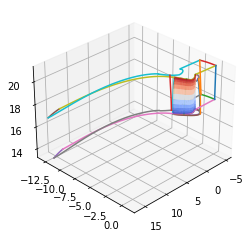

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_block_outline(blocks[0],ax)
plot_block_outline(blocks[1],ax)
plot_face(face_matches,blocks)
ax.view_init(30,45)

## Periodic Faces
Perodicity is a subset of connectivity. It relates to how Faces of blocks are connected when rotated by an angle. You can think of an apple pie and slice it up into equal slices. Say you put in a filling into one of those slices. The filling will splurge over to the other slices. This is kind of what perodicity means. Data goes into one slice, it is transfered into other slices. You can also think of the game portal.

In turbomachinery, simulating an entire turbine wheel requires many points, it is easier to break it into pie slices and apply periodicity/connectivity to the sides. 